In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, mean_absolute_error
%matplotlib inline 

In [3]:
# color dict (use: colors['XColor'])
import ast
with open('color_palette.txt', 'r') as file:
    contents = file.read()
    colors = ast.literal_eval(contents)

In [4]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [20]:
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
# for dataframes
algcol = ['knn_auto', 'dtree_auto', 'knn31', 'dtree31', 'knn113', 'dtree113']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']
tfrac = '_tset1.0_'

## 2nd, nope, 3rd Attempt to Mimic MLL but with Cross Validation
#### CV = 15, ~7% tested in each fold
#### CV = 10, 10% tested in each fold
#### CV = 5, 20% tested in each fold

(attempt 2 was using cross_validate, but attempt 3 is cross_val_predict so I'm not just getting averages back from each CV fold)

In [5]:
def rxtr_metrics(df, d, knn, dtr):
    dfmetric = 'Accuracy'
    dfstd = 'Acc Std'
    errname = 'AbsError'    
    for en_list in ['31', '_auto', '113']:
        for a, A, alg in zip(['knn', 'dtree'], ['kNN', 'DTree'], [knn, dtr]):
            df.loc[d, (a+en_list, dfmetric)] = balanced_accuracy_score(alg[en_list]['TrueY'], alg[en_list][A], adjusted=True)
            df.loc[d, (a+en_list, dfstd)] = alg[en_list][errname].std()
    return df

def reg_metrics(df, d, knn, dtr):
    dfmetric = 'Neg MAE'
    dfstd = 'MAE Std'
    errname = 'AbsError'    
    for en_list in ['31', '_auto', '113']:
        for a, A, alg in zip(['knn', 'dtree'], ['kNN', 'DTree'], [knn, dtr]):
            df.loc[d, (a+en_list, dfmetric)] = -mean_absolute_error(alg[en_list]['TrueY'], alg[en_list][A])
            df.loc[d, (a+en_list, dfstd)] = alg[en_list][errname].std()
    return df

In [114]:
csv_end = '_predictions.csv'
extra_dir = 'cv_pred/'
results5 = {}
results10 = {}
results15 = {}
results = {'5' : results5, '10' : results10, '15' : results15}
for p in pred:
    if p == 'reactor':
        levels = [algcol, scrcol]
        dfmetric = 'Accuracy'
        dfstd = 'Acc Std'
    else: 
        levels = [algcol, errcol]
        dfmetric = 'Neg MAE'
        dfstd = 'MAE Std'
    for cv, cv_dir in zip(['5', '10', '15'], ['cv5/', 'cv10/', 'cv15/']):
        df = pd.DataFrame(index=dets, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
        for d in dets:
            learn_path = learn_gam + extra_dir + cv_dir
            knncsv = p + '_knn' + tfrac + 'cv' + str(cv) + '_' + d + csv_end
            dtrcsv = p + '_dtree' + tfrac + 'cv' + str(cv) + '_' + d + csv_end
            if 'nuc' in d or 'act' in d:
                if d == 'act4/9':
                    knncsv = p + '_knn' + tfrac + 'cv' + str(cv) + '_' + 'act4' + csv_end
                    dtrcsv = p + '_dtree' + tfrac + 'cv' + str(cv) + '_' + 'act4' + csv_end
                    knn31 = pd.read_csv(learn_path + 'act4/' + knncsv).drop(columns='Unnamed: 0')
                    dtr31 = pd.read_csv(learn_path + 'act4/' + dtrcsv).drop(columns='Unnamed: 0')
                    knncsv = p + '_knn' + tfrac + 'cv' + str(cv) + '_' + 'act9' + csv_end
                    dtrcsv = p + '_dtree' + tfrac + 'cv' + str(cv) + '_' + 'act9' + csv_end
                    ##### applying act9 to auto, although this isn't accurate #####
                    knn_auto = knn113 = pd.read_csv(learn_path + 'act9/' + knncsv).drop(columns='Unnamed: 0')
                    dtr_auto = dtr113 = pd.read_csv(learn_path + 'act9/' + dtrcsv).drop(columns='Unnamed: 0')
                else:
                    if 'nuc' in d:
                        learn_path = learn_nuc + extra_dir + cv_dir
                    knn_auto = knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
                    dtr_auto = dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
            else:
                knn_auto = pd.read_csv(learn_path + 'auto/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = pd.read_csv(learn_path + 'auto/' + dtrcsv).drop(columns='Unnamed: 0')
                knn31 = pd.read_csv(learn_path + 'n31/' + knncsv).drop(columns='Unnamed: 0')
                dtr31 = pd.read_csv(learn_path + 'n31/' + dtrcsv).drop(columns='Unnamed: 0')
                knn113 = pd.read_csv(learn_path + 'n113/' + knncsv).drop(columns='Unnamed: 0')
                dtr113 = pd.read_csv(learn_path + 'n113/' + dtrcsv).drop(columns='Unnamed: 0')
            # Error Calcs
            knn = {'31' : knn31, '_auto' : knn_auto, '113' : knn113}
            dtr = {'31' : dtr31, '_auto' : dtr_auto, '113' : dtr113}
            if p == 'reactor':        
                df = rxtr_metrics(df, d, knn, dtr)
            else:
                df = reg_metrics(df, d, knn, dtr)
        results[cv][p] = df

KeyboardInterrupt: 

### Plotting

In [64]:
x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
_x = np.arange(len(x))
d_x = [-0.2, -0.1, 0.0, 0.1, 0.2, 0.3]

In [ ]:
def plot_cv_curves(pred_param, title):
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(18,6))
    axs[1].set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        axs[0].set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        axs[0].set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    c = ['LBrwn', 'LTeal', 'MBrwn', 'MTeal', 'DBrwn', 'DTeal']
    lbl = ['kNN Auto', 'Dec Tree Auto', 'kNN 31', 'Dec Tree 31', 'kNN 113', 'Dec Tree 113']
    for cv, ax in zip(['5', '10', '15', '0'], axs):
        ax.set_title('CV = ' + cv, fontsize=16, pad=15)
        if cv == '0':
            plotdf = no_cv_results[pred_param]
        else:
            plotdf = results[cv][pred_param]
        for i, alg in enumerate(algcol):
            y = np.array(plotdf[alg][metric], dtype=float)
            sd = np.array(plotdf[alg][std], dtype=float)
            #_, _, bars = ax.errorbar(_x+d_x[i], y, yerr=sd, color=colors[c[i]], marker='o', linestyle='None', mew=0, ms=6, elinewidth=3, label=lbl[i])
            #[bar.set_alpha(0.7) for bar in bars]
            #plt.xticks(_x, x)
            ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
            ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.35)
        ax.tick_params(labelsize=12, labelrotation=45)
        ax.legend(loc='lower right')
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=.85)
    plt.show()

In [ ]:
plot_cv_curves('reactor', 'Reactor Type Prediction')

In [ ]:
plot_cv_curves('burnup', 'Burnup Prediction')

In [ ]:
plot_cv_curves('enrichment', 'U235 Enrichment Prediction')

In [ ]:
plot_cv_curves('cooling', 'Time Since Irradiation Prediction')

## 1st Attempt to Mimic MLL: 6.7% test set, no cross validation

In [57]:
csv_end = '_mimic_mll.csv'
extra_dir = 'test_0.067_only/'
no_cv_results = {}
for p in pred:
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=dets, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for d in dets:
        learn_path = learn_gam + extra_dir
        knncsv = p + '_knn' + tfrac + d + csv_end
        dtrcsv = p + '_dtree' + tfrac + d + csv_end
        if 'nuc' in d or 'act' in d:
            if d == 'act4/9':
                knncsv = p + '_knn' + tfrac + 'act4' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act4' + csv_end
                knn31 = pd.read_csv(learn_path + 'act4/' + knncsv).drop(columns='Unnamed: 0')
                dtr31 = pd.read_csv(learn_path + 'act4/' + dtrcsv).drop(columns='Unnamed: 0')
                knncsv = p + '_knn' + tfrac + 'act9' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act9' + csv_end
                ##### applying act9 to auto, although this isn't accurate #####
                knn_auto = knn113 = pd.read_csv(learn_path + 'act9/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr113 = pd.read_csv(learn_path + 'act9/' + dtrcsv).drop(columns='Unnamed: 0')
            else:
                if 'nuc' in d:
                    learn_path = learn_nuc + extra_dir
                knn_auto = knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        else:
            knn_auto = pd.read_csv(learn_path + 'auto/' + knncsv).drop(columns='Unnamed: 0')
            dtr_auto = pd.read_csv(learn_path + 'auto/' + dtrcsv).drop(columns='Unnamed: 0')
            knn31 = pd.read_csv(learn_path + 'n31/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = pd.read_csv(learn_path + 'n31/' + dtrcsv).drop(columns='Unnamed: 0')
            knn113 = pd.read_csv(learn_path + 'n113/' + knncsv).drop(columns='Unnamed: 0')
            dtr113 = pd.read_csv(learn_path + 'n113/' + dtrcsv).drop(columns='Unnamed: 0')
        
        # Error Calcs
        knn = {'31' : knn31, '_auto' : knn_auto, '113' : knn113}
        dtr = {'31' : dtr31, '_auto' : dtr_auto, '113' : dtr113}
        if p == 'reactor':        
            df = rxtr_metrics(df, d, knn, dtr)
        else:
            df = reg_metrics(df, d, knn, dtr)
    no_cv_results[p] = df

In [10]:
no_cv_results['reactor']

Algorithm  knn_auto           dtree_auto               knn31            \
Metric     Accuracy   Acc Std   Accuracy   Acc Std  Accuracy   Acc Std   
nuc29      0.970015  0.141194   0.969496  0.138187  0.970015  0.141194   
act32      0.985293  0.103231   0.979468  0.120904  0.985293  0.103231   
act4/9     0.848518  0.250212   0.871051  0.251671  0.483654  0.392072   
d1_hpge    0.309496  0.411747   0.683224  0.340597  0.728481   0.32292   
d2_hpge    0.284731  0.416559    0.65299  0.356712  0.695582  0.337105   
d3_czt     0.467737  0.403966   0.513984  0.392527   0.61925  0.359124   
d6_sri2    0.692461  0.327352    0.61474  0.357707  0.633169  0.342912   
d5_labr3   0.655347  0.342912   0.562001  0.377903  0.622069  0.343701   
d4_nai     0.495306  0.380379   0.448124  0.411864  0.540868  0.361665   

Algorithm   dtree31              knn113            dtree113            
Metric     Accuracy   Acc Std  Accuracy   Acc Std  Accuracy   Acc Std  
nuc29      0.969496  0.138187  0.970015  0.141194  0.969496  0.138187  
act32      0.979468  0.120904  0.985293  0.103231  0.979468  0.120904  
act4/9      0.52543  0.393857  0.848518  0.250212  0.871051  0.251671  
d1_hpge     0.70057  0.333394  0.724762  0.323599  0.774049  0.303762  
d2_hpge    0.689053  0.337253  0.625286  0.347701  0.735925   0.32042  
d3_czt     0.598429  0.375329  0.616621  0.358137  0.630315  0.359223  
d6_sri2    0.599499  0.366197  0.621772  0.336361  0.690703  0.338878  
d5_labr3    0.56612  0.368915  0.631769  0.339648  0.632913   0.35873  
d4_nai     0.577727  0.381617  0.534409  0.361471  0.557042   0.37634

### Plotting

In [54]:
x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
_x = np.arange(len(x))
d_x = [-0.2, -0.1, 0, 0.1, 0.2, 0.3]

In [11]:
def plot_curves(pred_param, title, plotdf):
    plt.clf()
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        ax.set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
    c = ['LBrwn', 'LTeal', 'MBrwn', 'MTeal', 'DBrwn', 'DTeal']
    lbl = ['kNN Auto', 'Dec Tree Auto', 'kNN 31', 'Dec Tree 31', 'kNN 113', 'Dec Tree 113']
    for i, alg in enumerate(algcol):
        y = np.array(plotdf[alg][metric], dtype=float)
        sd = np.array(plotdf[alg][std], dtype=float)
        ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
        ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.2)
    
    ax.tick_params(labelsize=12)
    ax.legend(loc='best')
    plt.show()

<Figure size 432x288 with 0 Axes>

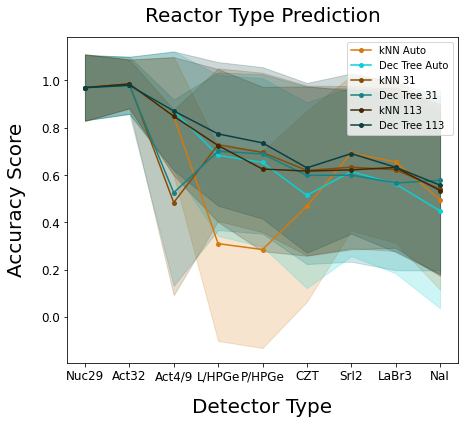

In [12]:
pred_param = 'reactor'
plot_curves(pred_param, 'Reactor Type Prediction', no_cv_results[pred_param])

<Figure size 432x288 with 0 Axes>

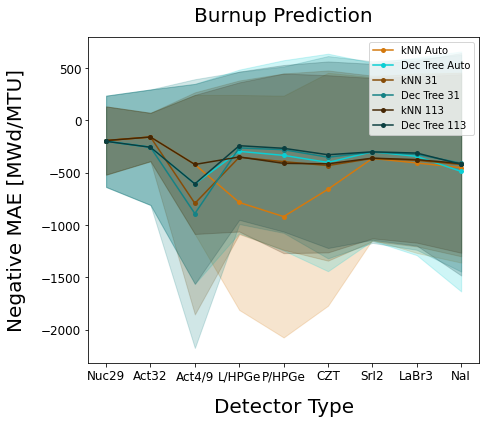

In [13]:
pred_param = 'burnup'
plot_curves(pred_param, 'Burnup Prediction', no_cv_results[pred_param])

<Figure size 432x288 with 0 Axes>

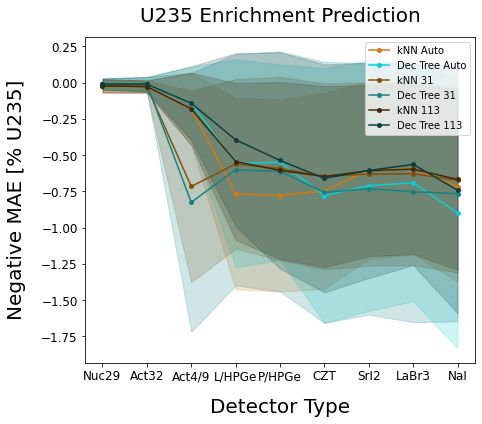

In [14]:
pred_param = 'enrichment'
plot_curves(pred_param, 'U235 Enrichment Prediction', no_cv_results[pred_param])

<Figure size 432x288 with 0 Axes>

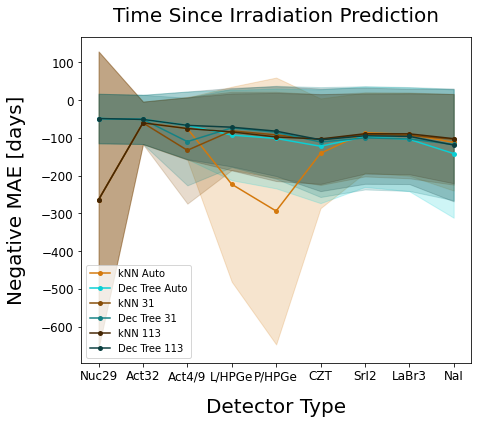

In [15]:
pred_param = 'cooling'
plot_curves(pred_param, 'Time Since Irradiation Prediction', no_cv_results[pred_param])

## Learning Curves

Tested a tangentially related "learning curve"...not by varying the trainset size but by varying the testset size. No curve was found in this misguided experiment

In [ ]:
# copied from htc_prep
fracs = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.23, 0.25, 0.27, 0.3]

In [7]:
def grab_data(pred, det, dirname):
    if 'nuc' in det:
        learn_path = learn_nuc + 'testset_learncurve'
    else:
        learn_path = learn_gam + 'testset_learncurve'
    k_data = []
    d_data = []
    for frac in fracs:
        knncsv = pred + '_knn_' + 'tset' + str(frac) + '_' + det + csv_end
        dtrcsv = pred + '_dtree_' + 'tset' + str(frac) + '_' + det + csv_end
        knn = pd.read_csv(learn_path + dirname + '/' + knncsv).drop(columns='Unnamed: 0')
        dtr = pd.read_csv(learn_path + dirname + '/' + dtrcsv).drop(columns='Unnamed: 0')
        for col, alg in zip(['kNN', 'DTree'], [knn, dtr]):
            if pred == 'reactor':        
                y = balanced_accuracy_score(alg['TrueY'], alg[col], adjusted=True)
            else:
                y = -mean_absolute_error(alg['TrueY'], alg[col])
            std = alg['AbsError'].std()
            if col == 'kNN':
                k_data.append((y, std))
            else:
                d_data.append((y, std))
    return k_data, d_data

In [ ]:
def plot_learncurves(pred_param, det_idx, dirname):
    plt.clf()
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    ax.set_title(pred_param + ' ' + dets[det_idx], fontsize=16, pad=15)
    ax.set_xlabel('Fraction of Trainset DB for Testset', fontsize=16, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=16, labelpad=15)
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        ax.set_ylabel(yaxlbl, fontsize=16, labelpad=15)
    
    x = fracs
    c = ['MBrwn', 'MTeal']
    lbl = ['kNN', 'Dec Tree']
    knn, dtr = grab_data(pred_param, dets[det_idx], dirname)
    for i, data in enumerate([knn, dtr]):
        y = np.array([d[0] for d in data])
        sd = np.array([d[1] for d in data])
        ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
        ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.2)
    
    ax.tick_params(labelsize=12)
    ax.legend(loc='best')
    plt.show()

In [ ]:
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
# do not use idx of 2 since code can't handle it

<Figure size 432x288 with 0 Axes>

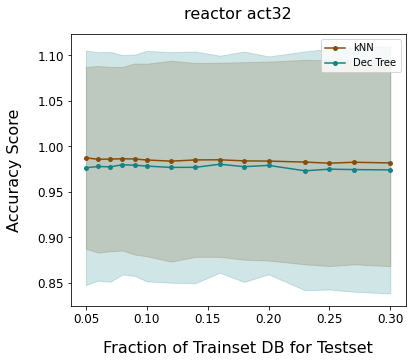

<Figure size 432x288 with 0 Axes>

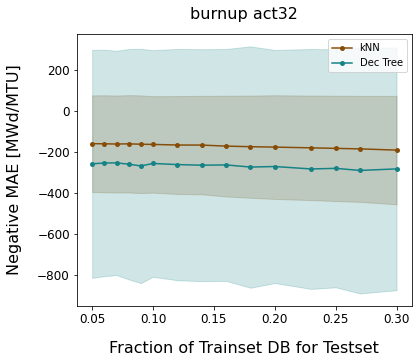

<Figure size 432x288 with 0 Axes>

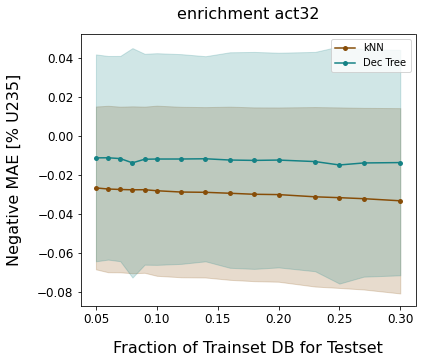

<Figure size 432x288 with 0 Axes>

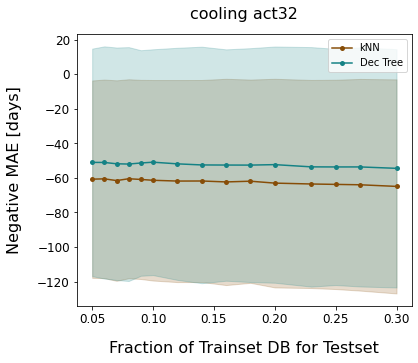

In [20]:
for p in pred:
    plot_learncurves(p, 1, 'act32')

<Figure size 432x288 with 0 Axes>

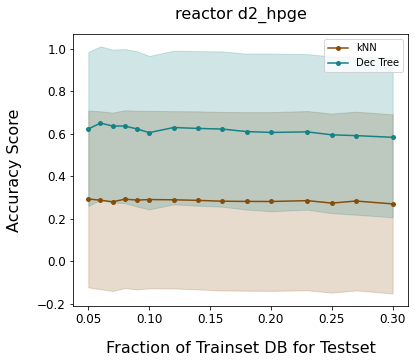

<Figure size 432x288 with 0 Axes>

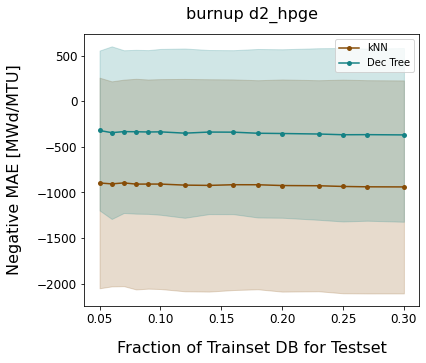

<Figure size 432x288 with 0 Axes>

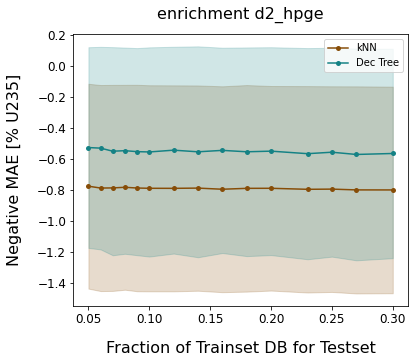

<Figure size 432x288 with 0 Axes>

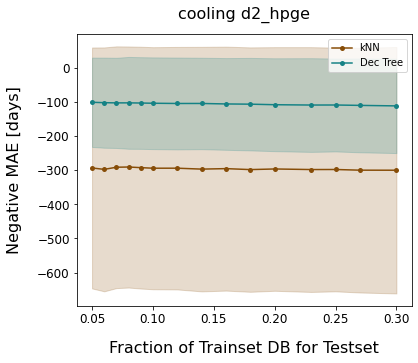

In [21]:
for p in pred:
    plot_learncurves(p, 4, 'auto')

<Figure size 432x288 with 0 Axes>

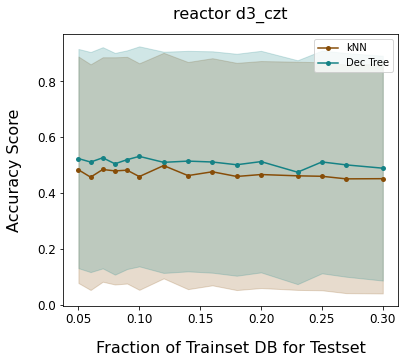

<Figure size 432x288 with 0 Axes>

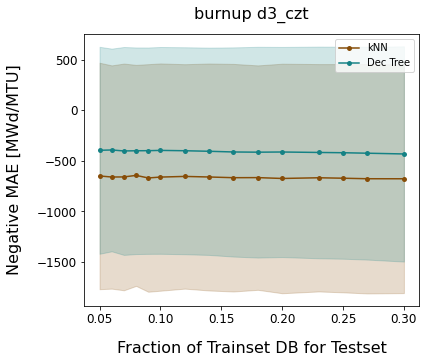

<Figure size 432x288 with 0 Axes>

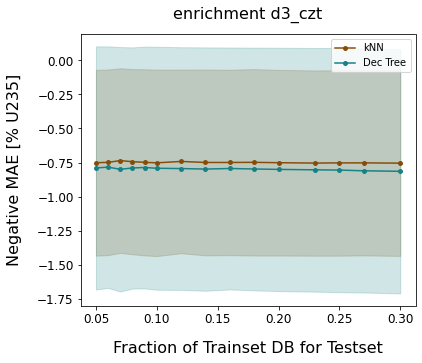

<Figure size 432x288 with 0 Axes>

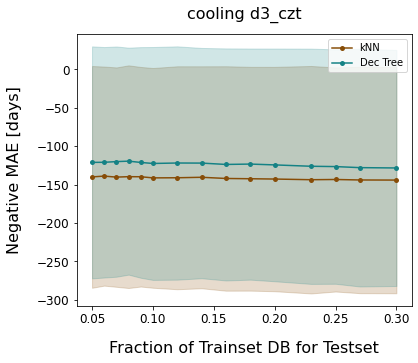

In [22]:
for p in pred:
    plot_learncurves(p, 5, 'auto')